<a href="https://colab.research.google.com/github/narayanacharyuluchitroju/DeepLearningModels/blob/main/02_YOLOv8_Basic_Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1 style="font-size:30px;">Training Ultralytics YOLOv8 on a Sample Dataset</h1>

<p align="center"><img src="https://opencv.org/wp-content/uploads/2023/03/c3_v2_week8_basic_training_poster_image.png" width=800></p>

To get our hands dirty with Object Detection, in this notebook, we will start with a simple object detection problem.

Although we will not go into the depths (which we will cover in later modules) of each step for training an object detection, you will still get a complete overview.

To make things simpler and more interesting, we are going to use the Ultralytics package for training a YOLOv8 model. We will be training the model on a dataset containing different types of animals in an aquarium. The dataset has been sourced from [Roboflow](https://public.roboflow.com/object-detection/aquarium/health) and modified according to the requirement.

## Table of Contents
* [Install the Ultralytics Package](#Install-the-Ultralytics-Package)
* [Download the Dataset](#Download-the-Dataset)
* [Visualize Dataset](#Visualize-Dataset)
* [Create the Model YAML File](#Create-the-Model-YAML-File)
* [YOLOv8 Training](#YOLOv8-Training)
* [Inference](#Inference)
* [Visualize Validation Results](#Visualize-Validation-Results)
* [Conclusion](#Conclusion)

## Install the Ultralytics Package

The first step is to install the Ultralytics package. All the latest YOLOv8 models are available through package.

In fact, the redefined library not provides the `yolo` CLI to make the process of training and inference even smoother.

In [ ]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 870.5/870.5 kB 18.6 MB/s eta 0:00:00


Executing the above command will install the major dependencies also, which include:
* Torch
* Torchvision

In [ ]:
import requests
import zipfile
import os
import glob
import cv2
import matplotlib.pyplot as plt
import random

In [ ]:
%matplotlib inline

## Download the Dataset

This sections downloads the aquarium dataset and extracts the zip file.

In [ ]:
def download_file(url, save_name):
    url = url
    if not os.path.exists(save_name):
        file = requests.get(url)
        open(save_name, 'wb').write(file.content)

In [ ]:
def unzip(zip_file=None):
    try:
        with zipfile.ZipFile(zip_file) as z:
            z.extractall("./")
            print("Extracted all")
    except:
        print("Invalid file")

In [ ]:
download_file(
    'https://www.dropbox.com/s/9qq0hw3203aggma/aquarium_dataset.zip?dl=1',
    'aquarium_dataset.zip'
)

unzip(zip_file='aquarium_dataset.zip')

Extracted all


The dataset contains 448 training samples and 127 validation samples.

## Visualize Dataset

Let's visualize some of the ground truth images along with their annotations.

In [ ]:
classes = ['fish', 'jellyfish', 'penguin',
           'puffin', 'shark', 'starfish', 'stingray']

In [ ]:
# Function to convert bounding boxes in YOLO format to xmin, ymin, xmax, ymax.
def yolo2bbox(bboxes):
    xmin, ymin = bboxes[0]-bboxes[2]/2, bboxes[1]-bboxes[3]/2
    xmax, ymax = bboxes[0]+bboxes[2]/2, bboxes[1]+bboxes[3]/2
    return xmin, ymin, xmax, ymax

In [ ]:
def plot_box(image, bboxes, labels):
    # Need the image height and width to denormalize
    # the bounding box coordinates
    h, w, _ = image.shape
    for box_num, box in enumerate(bboxes):
        x1, y1, x2, y2 = yolo2bbox(box)
        # Denormalize the coordinates.
        xmin = int(x1*w)
        ymin = int(y1*h)
        xmax = int(x2*w)
        ymax = int(y2*h)

        thickness = max(2, int(w/275))

        cv2.rectangle(
            image,
            (xmin, ymin), (xmax, ymax),
            color=(0, 0, 255),
            thickness=thickness
        )
        cv2.putText(
            image,
            text=classes[int(labels[box_num])],
            org=(xmin, ymin-5),
            fontFace=cv2.FONT_HERSHEY_SIMPLEX,
            fontScale=1.5,
            color=(0, 0, 255),
            thickness=2,
            lineType=cv2.LINE_AA
        )
    return image

In [ ]:
# Function to plot images with the bounding boxes.
def plot(image_paths, label_paths, num_samples):
    all_images = []
    all_images.extend(glob.glob(image_paths+'/*.jpg'))
    all_images.extend(glob.glob(image_paths+'/*.JPG'))

    all_images.sort()

    num_images = len(all_images)

    plt.figure(figsize=(15, 12))
    for i in range(num_samples):
        j = random.randint(0,num_images-1)
        image_name = all_images[j]
        image_name = '.'.join(image_name.split(os.path.sep)[-1].split('.')[:-1])
        image = cv2.imread(all_images[j])
        with open(os.path.join(label_paths, image_name+'.txt'), 'r') as f:
            bboxes = []
            labels = []
            label_lines = f.readlines()
            for label_line in label_lines:
                label = label_line[0]
                bbox_string = label_line[2:]
                x_c, y_c, w, h = bbox_string.split(' ')
                x_c = float(x_c)
                y_c = float(y_c)
                w = float(w)
                h = float(h)
                bboxes.append([x_c, y_c, w, h])
                labels.append(label)
        result_image = plot_box(image, bboxes, labels)
        plt.subplot(2, 2, i+1)
        plt.imshow(result_image[:, :, ::-1])
        plt.axis('off')
    plt.subplots_adjust(wspace=1)
    plt.tight_layout()
    plt.show()

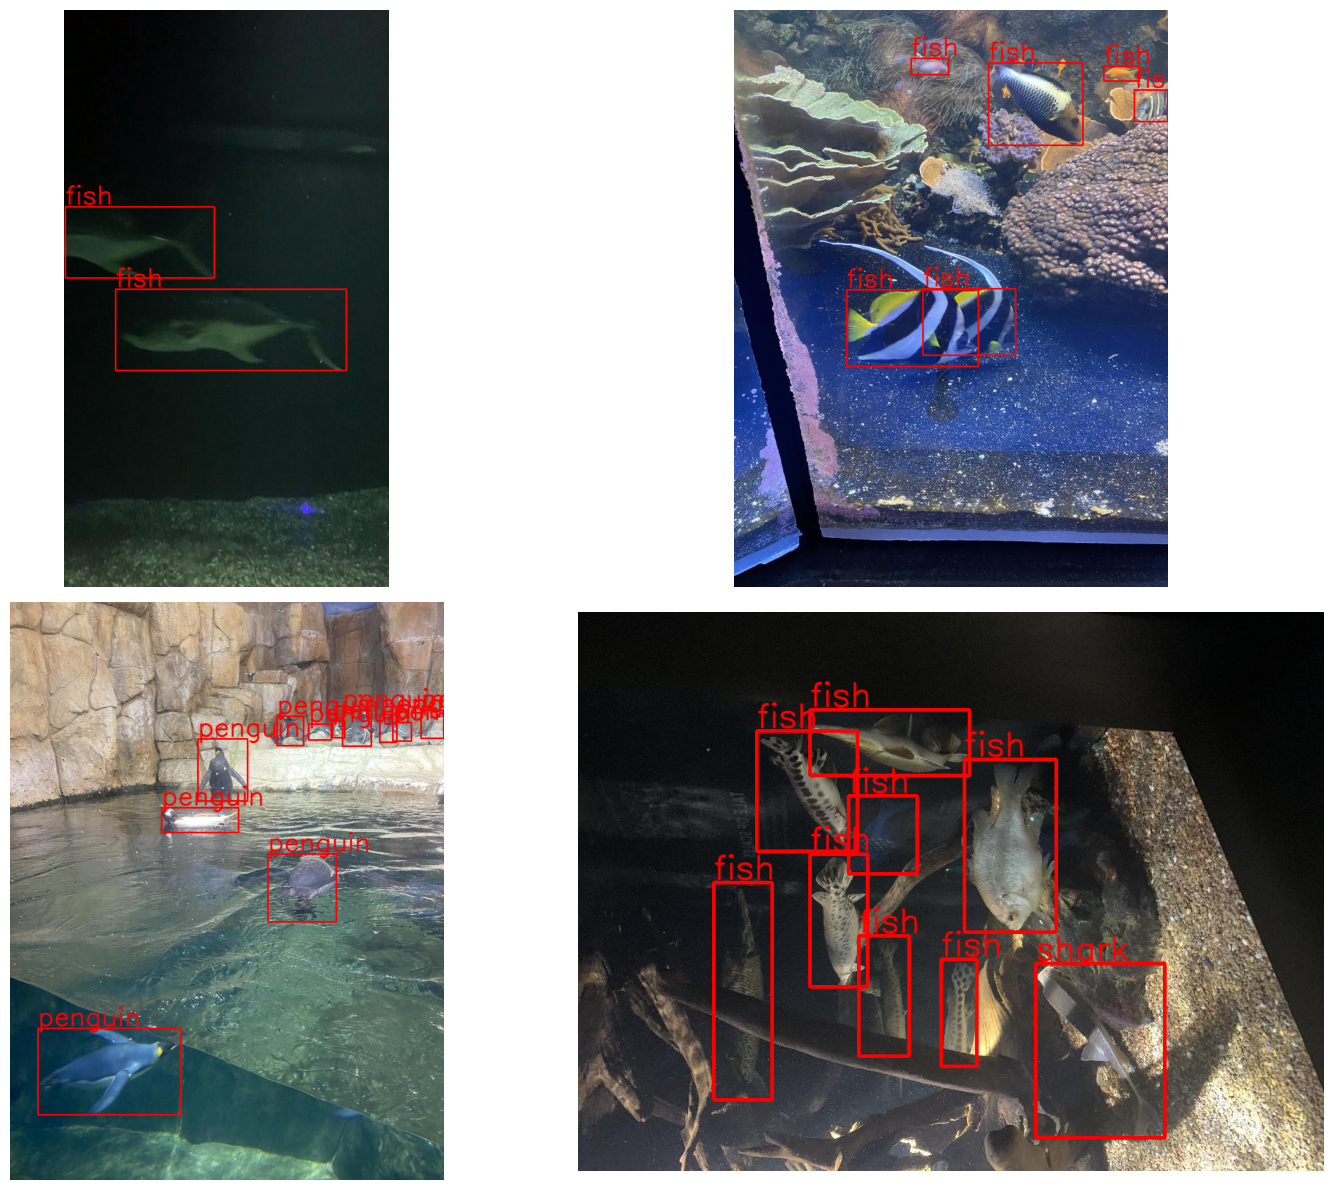

In [ ]:
# Visualize a few training images.
plot(
    image_paths='aquarium_dataset/train/images/',
    label_paths='aquarium_dataset/train/labels/',
    num_samples=4,
)

As you can see, the dataset contains different types of fish, penguin, and puffin birds in varied aquarium environment. The dataset contains 7 classes.

## Create the Model YAML File

All Ultralytics YOLO models need a dataset YAML file. Here we define the dataset attributes which include:
* The path to the root dataset directory.
* Path to the training images.
* Path to the validation images.
* The class names.

In our cases, first, we are defining a dictionary called `attr` containing all the necessary key-value pair. Then we write the dictionary as a YAML file to disk with the name `aquarium.yaml`.

In [ ]:
cwd = os.getcwd()
print(cwd)

/content


In [ ]:
import yaml

attr = {
    'path': cwd+'/aquarium_dataset',
    'train': 'train/images',
    'val': 'valid/images',
    'test': 'test/images',

    'names': {
          0: 'fish',
          1: 'jellyfish',
          2: 'penguin',
          3: 'puffin',
          4: 'shark',
          5: 'starfish',
          6: 'stingray',
    }
}

In [ ]:
with open('aquarium.yaml', 'w') as f:
    yaml.dump(attr, f)

## YOLOv8 Training

Here, we are training a nano YOLOv8 model (`yolov8n`) on the dataset for 10 epochs. We are using images of 640x640 resolution and a batch size of 32.

It may take somewhere between half an hour to an hour for the training to complete depending the hardware you are running the training on.

In [ ]:
EPOCHS = 15
!yolo task=detect mode=train model=yolov8n.pt imgsz=640 data=aquarium.yaml epochs={EPOCHS} batch=32 name=yolov8n

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
100% 6.25M/6.25M [00:00<00:00, 78.8MB/s]
Ultralytics 8.3.13 🚀 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=aquarium.yaml, epochs=15, time=None, patience=100, batch=32, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=yolov8n, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False

## Inference

In this section, we will run inference using the best trained model on the validation images.

In [ ]:
!yolo predict \
model=runs/detect/yolov8n/weights/best.pt \
source=aquarium_dataset/valid/images \
imgsz=640 \
name=yolov8n2 \
show_labels=True \
save=True

Ultralytics 8.3.13 🚀 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 186 layers, 2,685,733 parameters, 0 gradients, 6.8 GFLOPs

image 1/127 /content/aquarium_dataset/valid/images/IMG_2277_jpeg_jpg.rf.86c72d6192da48d941ffa957f4780665.jpg: 640x480 15 fishs, 36.7ms
image 2/127 /content/aquarium_dataset/valid/images/IMG_2278_jpeg_jpg.rf.3c7006d683b0fc62b9b5d84a2868c31c.jpg: 640x480 5 fishs, 6.6ms
image 3/127 /content/aquarium_dataset/valid/images/IMG_2279_jpeg_jpg.rf.c93235205522529fc7e9626bf9175cba.jpg: 640x480 28 fishs, 6.8ms
image 4/127 /content/aquarium_dataset/valid/images/IMG_2288_jpeg_jpg.rf.18da58173e72084ebd73149bc8914ec1.jpg: 640x480 1 puffin, 6.5ms
image 5/127 /content/aquarium_dataset/valid/images/IMG_2297_jpeg_jpg.rf.a7b46f3c112b1c319d824598ee1aafd5.jpg: 640x480 1 penguin, 1 puffin, 6.2ms
image 6/127 /content/aquarium_dataset/valid/images/IMG_2305_jpeg_jpg.rf.9590ed0a48add800dc5ea8d3f85d3469.jpg: 640x480 1 penguin, 10.4ms
image 7/127 /conten

## Visualize Validation Results

Let's visualize some of the inference results.

In [ ]:
def visualize(result_dir, num_samples=4):
    """
    Function accepts a directory path of images and randomly
    selects 4 images, plotting them in a 2x2 grid.
    """
    plt.figure(figsize=(20, 12))

    # Get a sorted list of image file paths in the directory
    image_names = sorted(glob.glob(os.path.join(result_dir, '*.jpg')))

    # Randomly select `num_samples` images
    random_images = random.sample(image_names, num_samples)

    for i, image_name in enumerate(random_images):
        image = plt.imread(image_name)
        plt.subplot(2, 2, i+1)
        plt.imshow(image)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

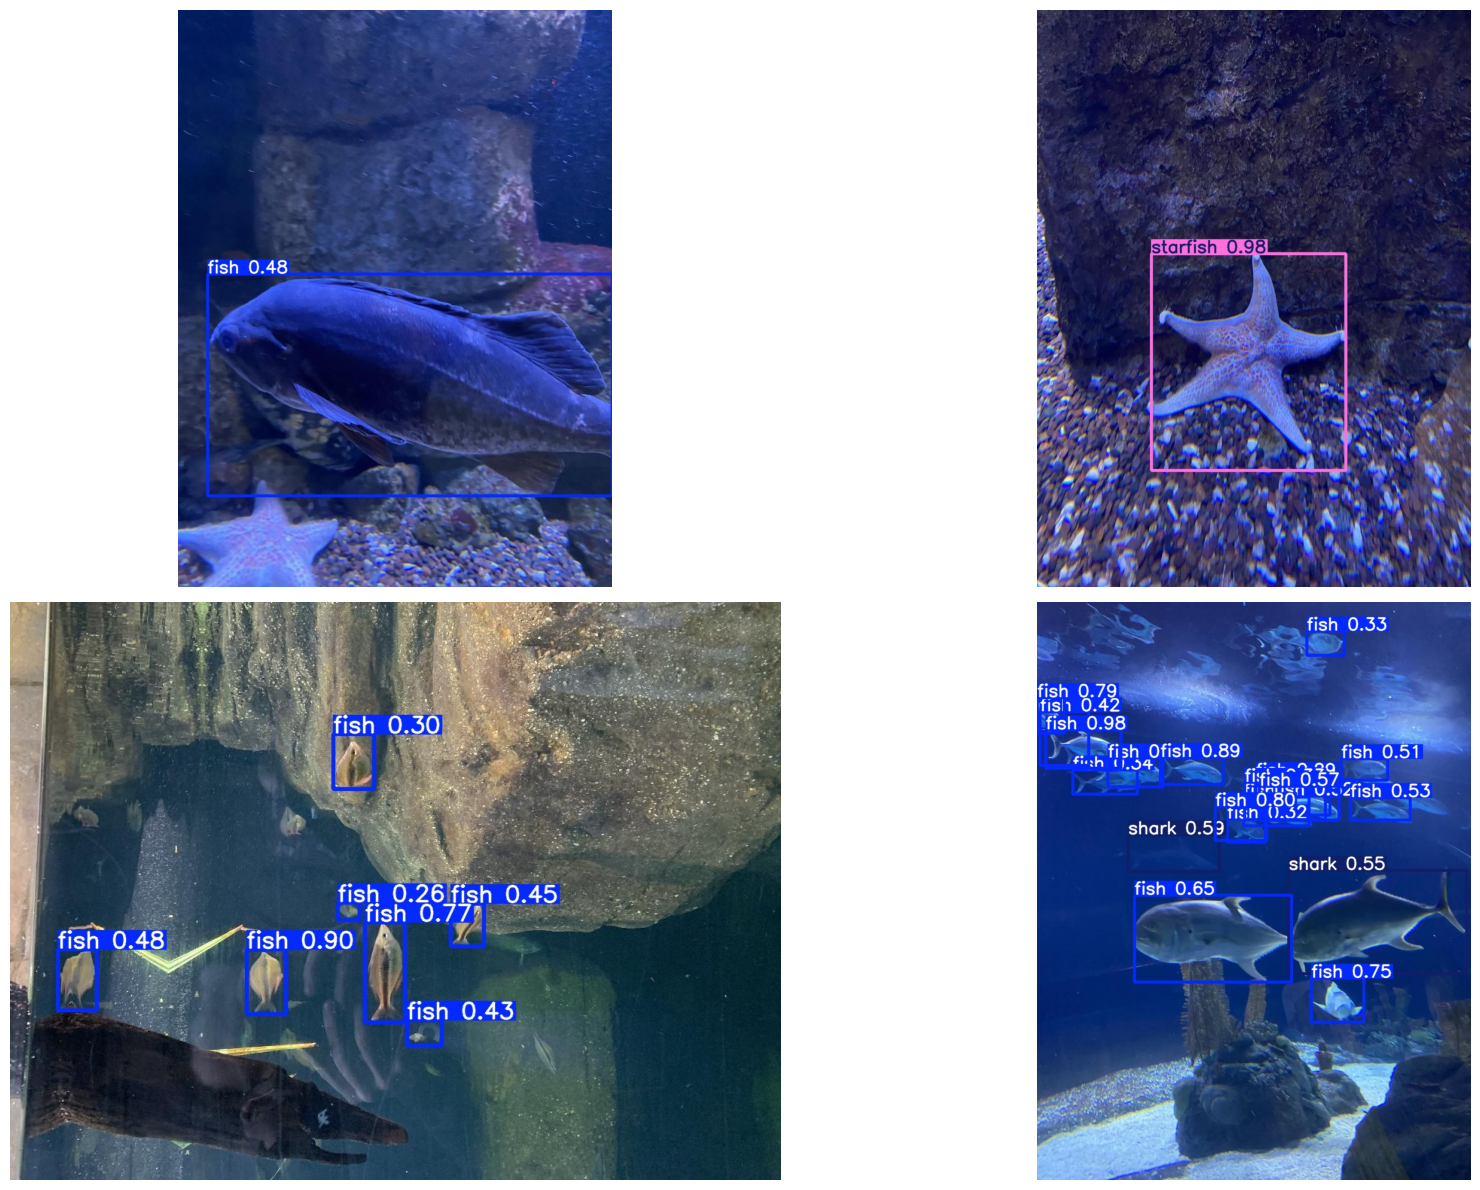

In [ ]:
visualize('runs/detect/yolov8n2')

## Conclusion
The above results are good but not great. In some of the images, the model is detecting `fish` as `shark`. In other images, it is unable to detect all the fish and jelly fish.

In upcoming modules, we will see how training larger models for more epochs can give us almost perfect results on the same dataset.